In [3]:
import pandas as pd
import numpy as np
import iisignature 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
#If you haven't install iisignature,use the code:   pip install iisignature


 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#Load the dataset
stock_data = pd.read_csv("stock_details_5_years.csv")


In [5]:
#Parsing the date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None).dt.date

In [6]:
#Calculating daily returns
stock_data['Return'] = stock_data.groupby('Company')['Close'].pct_change()
stock_data['OReturn'] = stock_data.groupby('Company')['Open'].pct_change()
stock_data.dropna(subset=['Return'], inplace=True)
stock_data.dropna(subset=['OReturn'], inplace=True)








In [7]:
#Delete useless company
target_date = pd.Timestamp('2022-02-01')
valid_companies = stock_data.loc[stock_data['Date'] == target_date, 'Company'].unique()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [8]:
#Retain company data that exists on the target date
stock_data = stock_data[stock_data['Company'].isin(valid_companies)]


In [9]:
#Data for simulate
start_date = pd.Timestamp('2022-02-01')
end_date = pd.Timestamp('2022-05-04')

#Get data for a specific time period
simulate_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]








In [10]:
unique_dates_count = simulate_stock_data['Date'].nunique()
print(unique_dates_count)

unique_companys_count = simulate_stock_data['Company'].nunique()
print(unique_companys_count)


65
486


In [11]:
#Calculate mean &std of data
company_stats_C = simulate_stock_data.groupby('Company')['Return'].agg(['mean', 'std']).rename(columns={'mean': 'cmiu', 'std': 'csigma'})
company_stats_O = simulate_stock_data.groupby('Company')['OReturn'].agg(['mean', 'std']).rename(columns={'mean': 'omiu', 'std': 'osigma'})


#Simulate the return and open return
np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_C, on='Company')
simulate_stock_data['sim_creturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['cmiu'], row['csigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['cmiu', 'csigma'])


np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_O, on='Company')
simulate_stock_data['sim_oreturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['omiu'], row['osigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['omiu', 'osigma'])

simulate_stock_data['sim_Close'] = np.nan
simulate_stock_data['sim_Open'] = np.nan


# Sort the data by Company and Date
simulate_stock_data = simulate_stock_data.sort_values(by=['Company', 'Date'])

# Function to calculate simulated close and open prices
def calculate_sim(group):
    group = group.sort_values(by='Date').reset_index(drop=True)
    for i in range(len(group)):
        if i == 0:
            group.at[i, 'sim_Close'] = group.at[i, 'Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i, 'Open'] * (1 + group.at[i, 'sim_oreturn'])
        else:
            group.at[i, 'sim_Close'] = group.at[i - 1, 'sim_Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i - 1, 'sim_Open'] * (1 + group.at[i, 'sim_oreturn'])
    return group

# Apply the function to each group of companies
simulate_stock_data = simulate_stock_data.groupby('Company').apply(calculate_sim).reset_index(drop=True)


In [12]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,OReturn,sim_creturn,sim_oreturn,sim_Close,sim_Open
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,0.023376,-0.006342,-0.006503,138.449131,137.935889
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,0.003273,-0.000777,-0.001163,138.341513,137.775466
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,0.007163,-0.000790,-0.001175,138.232193,137.613522
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,-0.003662,-0.003087,-0.003380,137.805460,137.148438
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,0.000141,-0.001082,-0.001455,137.656398,136.948869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31585,2022-04-28,176.760557,179.859887,175.872205,178.961670,2339000,0.0,0.0,ZTS,0.015913,0.006463,-0.004487,-0.004540,178.792577,179.269507
31586,2022-04-29,177.668636,179.504546,174.500205,174.954254,2251800,0.0,0.0,ZTS,-0.022393,0.005137,-0.002878,-0.002972,178.278020,178.736635
31587,2022-05-02,174.105377,174.954239,169.328069,172.407654,3513000,0.0,0.0,ZTS,-0.014556,-0.020056,-0.001478,-0.001608,178.014555,178.449150
31588,2022-05-03,172.417564,174.579202,171.341685,172.871613,2152200,0.0,0.0,ZTS,0.002691,-0.009694,-0.004914,-0.004956,177.139840,177.564801


In [13]:
# Def fuc to calculate signature 
def calculate_signature(data):
    company = data['Company'].iloc[0]
    date = data['Date'].iloc[0]
    company_data = simulate_stock_data[(simulate_stock_data['Company'] == company) & (simulate_stock_data['Date'] <= date)]
    if len(company_data) > 0:
        close_values = company_data['sim_Close'].values.reshape(-1, 1)  #Convert to a 2D array
        volume_values = company_data['sim_Open'].values.reshape(-1, 1)   #Convert to a 2D array
        #Compute first-order and second-order signatures
        signature_close_1 = iisignature.sig(close_values, 1)
        signature_volume_1 = iisignature.sig(volume_values, 1)
        signature_close_2 = iisignature.sig(close_values, 2)
        signature_volume_2 = iisignature.sig(volume_values, 2)
        #Concatenate signature data
        signature = np.concatenate((signature_close_1, signature_volume_1, signature_close_2, signature_volume_2), axis=None)
        return pd.Series({'Signature': signature})
    else:
        return pd.Series({'Signature': (0,0,0,0,0,0)})

#Calculate the signature
signatures = simulate_stock_data.groupby(['Company', 'Date']).apply(calculate_signature)
simulate_stock_data = simulate_stock_data.merge(signatures, left_on=['Company', 'Date'], right_index=True)


In [14]:
#Change 1 col into 6
simulate_stock_data[['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']] = pd.DataFrame(simulate_stock_data['Signature'].tolist(), index=simulate_stock_data.index)

#Delete old col
simulate_stock_data = simulate_stock_data.drop(columns=['Signature'])




In [15]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,...,sim_creturn,sim_oreturn,sim_Close,sim_Open,Signature1,Signature2,Signature3,Signature4,Signature5,Signature6
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,...,-0.006342,-0.006503,138.449131,137.935889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,...,-0.000777,-0.001163,138.341513,137.775466,-0.107618,-0.160424,-0.107618,0.005791,-0.160424,0.012868
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,...,-0.000790,-0.001175,138.232193,137.613522,-0.216938,-0.322368,-0.216938,0.023531,-0.322368,0.051960
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,...,-0.003087,-0.003380,137.805460,137.148438,-0.643671,-0.787451,-0.643671,0.207156,-0.787451,0.310039
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,...,-0.001082,-0.001455,137.656398,136.948869,-0.792733,-0.987020,-0.792733,0.314213,-0.987020,0.487104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31585,2022-04-28,176.760557,179.859887,175.872205,178.961670,2339000,0.0,0.0,ZTS,0.015913,...,-0.004487,-0.004540,178.792577,179.269507,-16.783049,-18.367387,-16.783049,140.835371,-18.367387,168.680447
31586,2022-04-29,177.668636,179.504546,174.500205,174.954254,2251800,0.0,0.0,ZTS,-0.022393,...,-0.002878,-0.002972,178.278020,178.736635,-17.297607,-18.900258,-17.297607,149.603599,-18.900258,178.609883
31587,2022-05-02,174.105377,174.954239,169.328069,172.407654,3513000,0.0,0.0,ZTS,-0.014556,...,-0.001478,-0.001608,178.014555,178.449150,-17.561072,-19.187743,-17.561072,154.195622,-19.187743,184.084748
31588,2022-05-03,172.417564,174.579202,171.341685,172.871613,2152200,0.0,0.0,ZTS,0.002691,...,-0.004914,-0.004956,177.139840,177.564801,-18.435786,-20.072093,-18.435786,169.939112,-20.072093,201.444461


In [16]:
#Extract true values
true_y = simulate_stock_data[simulate_stock_data['Date'] == pd.Timestamp('2022-05-04').date()][['Company', 'sim_Close']].rename(columns={'sim_Close': 'true_y'})

#Lasso regression for each company
results = []

for company in valid_companies:
    company_data = simulate_stock_data[simulate_stock_data['Company'] == company]
    
    train_x = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-01').date()) & (company_data['Date'] <= pd.Timestamp('2022-05-02').date())][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    train_y = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-03').date()) & (company_data['Date'] <= pd.Timestamp('2022-05-03').date())]['sim_Close']
    
    #Ensure train_x and train_y are aligned
    train_x = train_x.iloc[1:].reset_index(drop=True)
    train_y = train_y.reset_index(drop=True)
    
    #Perform LassoCV
    lasso = LassoCV(cv=5, random_state=2024)
    lasso.fit(train_x, train_y)
    
    #Predict the value
    test_x = company_data[company_data['Date'] == pd.Timestamp('2022-05-03').date()][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    predict_y = lasso.predict(test_x)[0]
    
    results.append({'Company': company, 'predicted_y': predict_y})

#Create results DataFrame
results_df = pd.DataFrame(results)

#Merge true values with predictions
sim_result = true_y.merge(results_df, on='Company')



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+00, tolerance: 5.665e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1975258968286653, tolerance: 1.191202880891091
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8563549089745379, tolerance: 0.7839686542971286
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.202724288932586, tolerance: 4.735942868321185
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.57408003447972, tolerance: 4.735942868321185
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7954981998735775, tolerance: 0.7025954454976853
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020209413331144788, tolerance: 0.020148513018071752
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006058452401502379, tolerance: 0.005410222063416816
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018157447990844844, tolerance: 0.005410222063416816
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e-02, tolerance: 5.617e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.857859857656649, tolerance: 4.272005662959011
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.458322370421229, tolerance: 7.4770281592456165
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2526150811751151, tolerance: 0.1845265526606419
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29996854201983325, tolerance: 0.1845265526606419
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.499e-01, tolerance: 3.217e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11994394869365976, tolerance: 0.11796990670722929
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15802571223170414, tolerance: 0.11796990670722929
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19275982548348924, tolerance: 0.11796990670722929
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020726461831982457, tolerance: 0.0018069161837371505
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002050200736697705, tolerance: 0.0018069161837371505
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019691363714695598, tolerance: 0.0018069161837371505
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022054428853171437, tolerance: 0.012682272868934736
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024266344323603306, tolerance: 0.0181310311899496
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04179568089381025, tolerance: 0.0181310311899496
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e-01, tolerance: 6.441e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0329596180194871, tolerance: 0.023415713000896964
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04712171020259914, tolerance: 0.023415713000896964
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055429905397861745, tolerance: 0.04865187066639081
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0634928196221729, tolerance: 0.04865187066639081
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06974817777107489, tolerance: 0.04865187066639081
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041911421862931064, tolerance: 0.03997406142349731
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04371448140885548, tolerance: 0.03997406142349731
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044897761690307014, tolerance: 0.03997406142349731
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e-02, tolerance: 1.761e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017949533174373755, tolerance: 0.01743563579942879
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11723771812569561, tolerance: 0.07303382658360015
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.294e-02, tolerance: 6.851e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028439515933646575, tolerance: 0.015383128637054069
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032613803931022645, tolerance: 0.015383128637054069
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\sit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.535e-03, tolerance: 2.547e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.278856254344646, tolerance: 0.22946948746782683
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25261782505094743, tolerance: 0.24261547232543618
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22943364308866876, tolerance: 0.20970729195775112
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24078651566551912, tolerance: 0.20970729195775112
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24710172710099698, tolerance: 0.20970729195775112
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8462868259066454, tolerance: 1.8346473242873025
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1790011268060425, tolerance: 1.8346473242873025
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.446533292771619, tolerance: 1.8346473242873025
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.950e-02, tolerance: 2.021e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e-02, tolerance: 3.056e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5484539055789615, tolerance: 0.2675576047961034
  model = cd_fast.enet_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008818086234447797, tolerance: 0.004928891585908754
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00958269503089415, tolerance: 0.004928891585908754
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009867861595060923, tolerance: 0.004928891585908754
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10425134137785008, tolerance: 0.1023861604217614
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19482476145776673, tolerance: 0.16543739565732268
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.208063536196903, tolerance: 0.18743333062843723
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0220451996267208, tolerance: 0.0196106834185919
  model = cd_fast.enet_coordinate_descent_gram(


In [17]:
#Calcilate difference
sim_result["difference"] = (sim_result["true_y"] - sim_result["predicted_y"]).abs()
sim_result["difference_percentage"] = (sim_result["difference"] / sim_result["true_y"]) * 100

#Sort by difference
sim_result_sorted = sim_result.sort_values(by="difference")


#Print first and last 10 lines
print("10 lines with lowest difference:")
print(sim_result_sorted.head(10))

# 打印后十行
print("\n 10 lines with highest difference:")
print(sim_result_sorted.tail(10))


10 lines with lowest difference:
    Company     true_y  predicted_y  difference  difference_percentage
154     ELP   5.985549     5.985438    0.000111               0.001855
299    MUFG   6.094377     6.094834    0.000456               0.007489
280     MFG   2.495409     2.495895    0.000487               0.019497
19      ALC  73.484609    73.484025    0.000583               0.000794
89      CHT  38.963696    38.963042    0.000654               0.001678
237    ITUB   4.450722     4.450056    0.000666               0.014964
438      TU  23.560025    23.559016    0.001009               0.004284
408     SYM   9.922354     9.923706    0.001352               0.013628
176      FE  40.737690    40.739461    0.001771               0.004347
157     ENB  40.954575    40.952768    0.001807               0.004413

 10 lines with highest difference:
    Company       true_y  predicted_y  difference  difference_percentage
61      BLK   656.095953   647.431968    8.663985               1.320536
38  

In [18]:
#Calculate overall R² score
overall_r2_score = r2_score(sim_result['true_y'], sim_result['predicted_y'])
print(f"R² score: {overall_r2_score}")

R² score: 0.9999192967069518


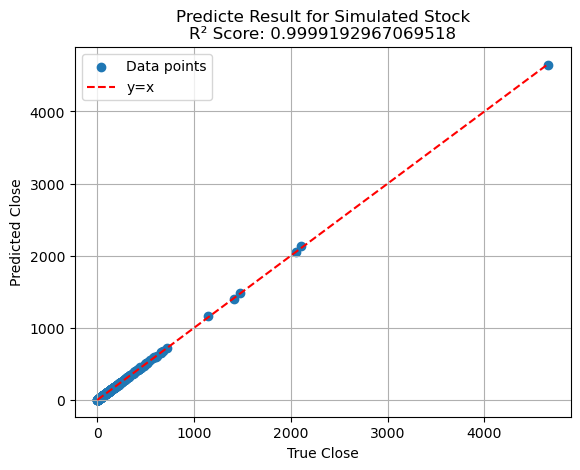

In [19]:
#Plot
plt.scatter(sim_result['true_y'], sim_result['predicted_y'], label='Data points')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title(f'Predicte Result for Simulated Stock\nR² Score: {overall_r2_score}')

plt.plot([sim_result['true_y'].min(), sim_result['true_y'].max()], [sim_result['true_y'].min(), sim_result['true_y'].max()], 'r--', label='y=x')
plt.legend()
plt.grid(True)
plt.show()